<a id='top'></a>

# Data Engineering of Wyscout Data
##### Notebook to engineer JSON Event data from [Wyscout](https://wyscout.com/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Last updated: 03/09/2020

![title](../../img/wyscout_logo.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers [Wyscout](https://wyscout.com/) JSON event data of football matches in the Big 5 European leagues for the 17/18 season using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [LinkedIn.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [GitHub/eddwebster](https://github.com/eddwebster/),
*    [Kaggle.com/eddwebster](https://www.kaggle.com/eddwebster), and
*    [HackerRank.com/eddwebster](https://www.hackerrank.com/eddwebster).

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/fifa-league/blob/master/FIFA%2020%20Fantasy%20Football%20League%20using%20TransferMarkt%20Player%20Valuations.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize
from ast import literal_eval

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Filepaths

In [3]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [ ]:
# Define custom function to read JSON files that also handles the encoding of special characters e.g. accents in names of players and teams
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

### Notebook Settings

In [ ]:
pd.set_option('display.max_columns', None)

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to engineer [Wyscout](https://wyscout.com/) JSON event data of football matches in the Big 5 European leagues for the 17/18 season using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

The resulting five engineered DataFrames for each of the Big 5 European league are exported to CSV files. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
[Wyscout](https://wyscout.com/) is an Italian company that supports football scouting, match analysis and transfer dynamics. The company was founded in Genoa, Italy in 2004 and provides video analysis tools and digital databases regarding performances and matches for coaches, teams and players dealing with football business.

The purpose is to allow them have a detailed sight of a large number of athletes about individual performances, patterns of play and tactical strategy.

This notebook explores a complete dataset of event data for the Big 5 European leagues during the 17/18 season.

A detailed description of the data can be found in the following paper:
- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

It is from this paper import the *matches*, *events*, *players*, *playerank*, *referees*, *coaches*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in `.json` format. 

The complete data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players.

The datasets we will be using are:
- competition
- events
- matches
- players


Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionary</a>
The [WyScout](https://www.transfermarkt.co.uk/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

### <a id='#section3.3'>3.3. Import Data</a>

In [4]:
df_wyscout_raw = pd.read_csv(data_dir_wyscout + '/raw/csv/combined/wyscout_big5_combined.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### <a id='#section3.4'>3.4. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [5]:
# Display the first 5 rows of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,height,wyId_x.1,foot,shortName,passportArea.name,role.name,birthArea.name,fullName,teamName,wyId_y.1
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Alexandre Lacazette,Arsenal,1609
1,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,...,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Alexandre Lacazette,Arsenal,1609
2,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,...,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Alexandre Lacazette,Arsenal,1609
3,8,Head pass,[{'id': 1802}],25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,...,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Alexandre Lacazette,Arsenal,1609
4,1,Ground defending duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,...,175,25413,right,A. Lacazette,Guadeloupe,Forward,France,Alexandre Lacazette,Arsenal,1609


In [6]:
# Display the last 5 rows of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,height,wyId_x.1,foot,shortName,passportArea.name,role.name,birthArea.name,fullName,teamName,wyId_y.1
2845352,8,Simple pass,[{'id': 1801}],516397,"[{'y': 68, 'x': 24}, {'y': 29, 'x': 10}]",2565924,Pass,677,2H,2315.506349,...,180,516397,NaN,Mujaid Sadick,Spain,Defender,Spain,Mujaid Sadick Aliu,Deportivo La Coru\u00f1a,677
2845353,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",516397,"[{'y': 65, 'x': 66}, {'y': 63, 'x': 80}]",2565924,Duel,677,2H,2394.530930,...,180,516397,NaN,Mujaid Sadick,Spain,Defender,Spain,Mujaid Sadick Aliu,Deportivo La Coru\u00f1a,677
2845354,3,Free Kick,[{'id': 1801}],516397,"[{'y': 70, 'x': 30}, {'y': 91, 'x': 26}]",2565924,Free Kick,677,2H,2511.297877,...,180,516397,NaN,Mujaid Sadick,Spain,Defender,Spain,Mujaid Sadick Aliu,Deportivo La Coru\u00f1a,677
2845355,8,Simple pass,[{'id': 1801}],516397,"[{'y': 68, 'x': 26}, {'y': 38, 'x': 24}]",2565924,Pass,677,2H,2516.092456,...,180,516397,NaN,Mujaid Sadick,Spain,Defender,Spain,Mujaid Sadick Aliu,Deportivo La Coru\u00f1a,677
2845356,8,Simple pass,[{'id': 1801}],516397,"[{'y': 71, 'x': 38}, {'y': 47, 'x': 45}]",2565924,Pass,677,2H,2701.375749,...,180,516397,NaN,Mujaid Sadick,Spain,Defender,Spain,Mujaid Sadick Aliu,Deportivo La Coru\u00f1a,677


In [7]:
# Print the shape of the raw DataFrame, ddf_wyscout_raw
print(df_wyscout_raw.shape)

(2845357, 43)


In [8]:
# Print the column names of the raw DataFrame, df_wyscout_raw
print(df_wyscout_raw.columns)

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'league_name', 'wyId_y', 'country', 'weight',
       'firstName', 'middleName', 'lastName', 'birthDate', 'height',
       'wyId_x.1', 'foot', 'shortName', 'passportArea.name', 'role.name',
       'birthArea.name', 'fullName', 'teamName', 'wyId_y.1'],
      dtype='object')


The dataset has six features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [9]:
# Data types of the features of the raw DataFrame, df_wyscout_raw
df_wyscout_raw.dtypes

eventId                int64
subEventName          object
tags                  object
playerId               int64
positions             object
matchId                int64
eventName             object
teamId                 int64
matchPeriod           object
eventSec             float64
subEventId           float64
id                     int64
status                object
roundId                int64
gameweek               int64
seasonId               int64
dateutc               object
winner                 int64
venue                 object
wyId_x                 int64
label                 object
date                  object
referees              object
duration              object
competitionId          int64
league_name           object
wyId_y                 int64
country               object
weight                 int64
firstName             object
middleName           float64
lastName              object
birthDate             object
height                 int64
wyId_x.1      

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [10]:
# Info for the raw DataFrame, df_wyscout_raw
df_wyscout_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2845357 entries, 0 to 2845356
Data columns (total 43 columns):
 #   Column             Dtype  
---  ------             -----  
 0   eventId            int64  
 1   subEventName       object 
 2   tags               object 
 3   playerId           int64  
 4   positions          object 
 5   matchId            int64  
 6   eventName          object 
 7   teamId             int64  
 8   matchPeriod        object 
 9   eventSec           float64
 10  subEventId         float64
 11  id                 int64  
 12  status             object 
 13  roundId            int64  
 14  gameweek           int64  
 15  seasonId           int64  
 16  dateutc            object 
 17  winner             int64  
 18  venue              object 
 19  wyId_x             int64  
 20  label              object 
 21  date               object 
 22  referees           object 
 23  duration           object 
 24  competitionId      int64  
 25  league_name       

In [11]:
# Description of the raw DataFrame, df_wyscout_raw, showing some summary statistics for each numberical column in the DataFrame
df_wyscout_raw.describe()

,eventId,playerId,matchId,teamId,eventSec,subEventId,id,roundId,gameweek,seasonId,winner,wyId_x,competitionId,wyId_y,weight,middleName,height,wyId_x.1,wyId_y.1
count,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.837564e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,2.845357e+06,0.0,2.845357e+06,2.845357e+06,2.845357e+06
mean,5.693304e+00,9.086818e+04,2.532543e+06,2.602999e+03,1.391895e+03,6.012407e+01,2.176981e+08,4.405858e+06,1.920911e+01,1.811753e+05,2.009395e+03,2.532543e+06,5.063107e+02,5.063107e+02,7.619891e+01,NaN,1.820422e+02,9.086818e+04,2.602999e+03
std,3.141016e+00,1.184798e+05,3.312629e+04,2.219126e+03,8.343107e+02,3.257677e+01,2.125972e+07,2.972835e+02,1.077176e+01,4.167794e+01,2.519555e+03,3.312629e+04,1.557932e+02,1.557932e+02,7.144579e+00,NaN,6.973521e+00,1.184798e+05,2.219126e+03
min,1.000000e+00,3.300000e+01,2.499719e+06,6.740000e+02,0.000000e+00,1.000000e+01,1.761216e+08,4.405517e+06,1.000000e+00,1.811370e+05,0.000000e+00,2.499719e+06,3.640000e+02,3.640000e+02,0.000000e+00,NaN,0.000000e+00,3.300000e+01,6.740000e+02
25%,1.000000e+00,9.414000e+03,2.500762e+06,1.612000e+03,6.626598e+02,1.300000e+01,2.006414e+08,4.405654e+06,1.000000e+01,1.811440e+05,6.740000e+02,2.500762e+06,4.120000e+02,4.120000e+02,7.200000e+01,NaN,1.780000e+02,9.414000e+03,1.612000e+03
50%,8.000000e+00,2.559600e+04,2.516893e+06,2.454000e+03,1.376945e+03,8.300000e+01,2.186668e+08,4.405655e+06,1.900000e+01,1.811500e+05,1.625000e+03,2.516893e+06,4.260000e+02,4.260000e+02,7.600000e+01,NaN,1.820000e+02,2.559600e+04,2.454000e+03
75%,8.000000e+00,1.371610e+05,2.565856e+06,3.197000e+03,2.110599e+03,8.500000e+01,2.337595e+08,4.406122e+06,2.800000e+01,1.811890e+05,3.164000e+03,2.565856e+06,5.240000e+02,5.240000e+02,8.100000e+01,NaN,1.860000e+02,1.371610e+05,3.197000e+03
max,1.000000e+01,5.685830e+05,2.576338e+06,1.983000e+04,3.537356e+03,1.000000e+02,2.562365e+08,4.406278e+06,3.800000e+01,1.812480e+05,1.983000e+04,2.576338e+06,7.950000e+02,7.950000e+02,1.010000e+02,NaN,2.030000e+02,5.685830e+05,1.983000e+04


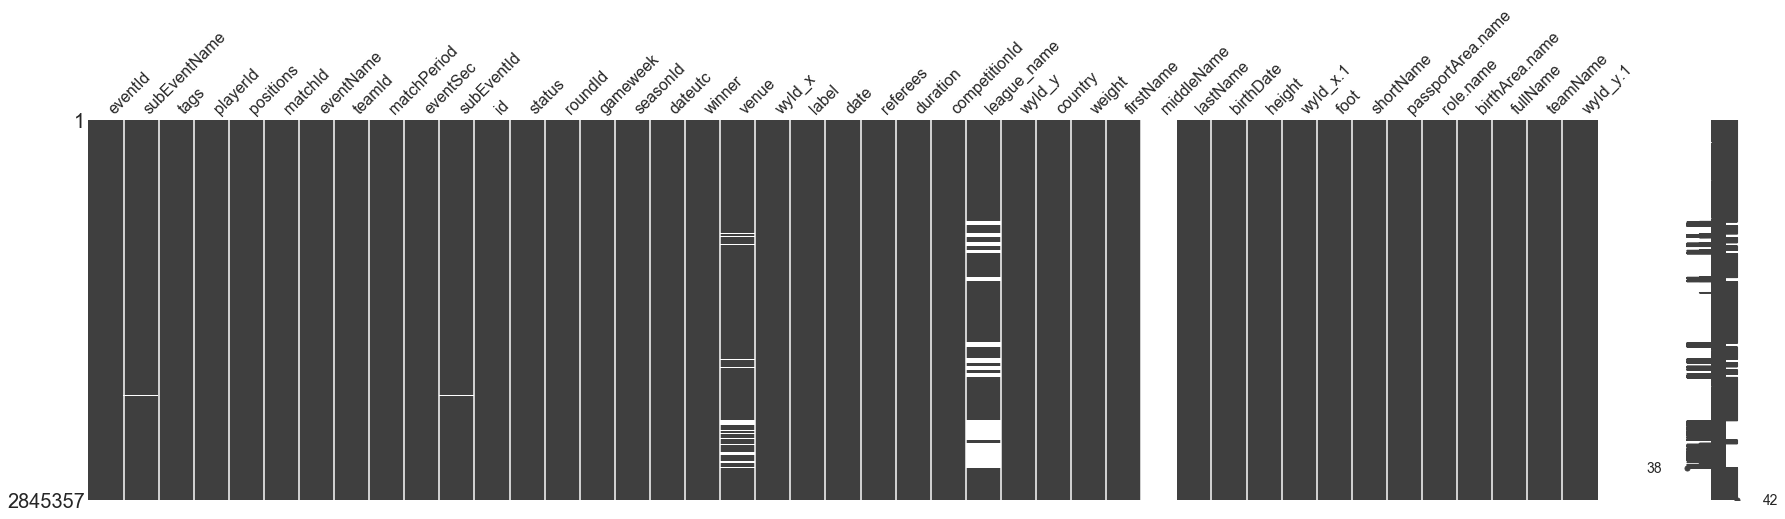

In [12]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout_raw
msno.matrix(df_wyscout_raw, figsize = (30, 7))

In [13]:
# Counts of missing values
tm_null_value_stats = df_wyscout_raw.isnull().sum(axis=0)
tm_null_value_stats[tm_null_value_stats != 0]

subEventName       7793
subEventId         7793
venue            166662
league_name      600585
middleName      2845357
foot                609
dtype: int64

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

---

## <a id='#section4'>4. Data Engineering</a>

### <a id='#section4.1'>4.1. Introduction</a>
...

### <a id='#section4.2'>4.2. Assign Raw DataFrame to Engineered DataFrame</a>

In [14]:
# Assign Raw DataFrame to Engineered DataFrame
df_wyscout = df_wyscout_raw

### <a id='#section4.2'>4.2. String Cleaning</a>

##### Split `Label` column into seperate `Fixture` and `Score` columns

In [15]:
# Break down 'Label' column into constituent parts - Fixtures, Score, Date, Home Goals, Away Goals, etc.
df_wyscout['fixture'] = df_wyscout['label'].str.split(', ').str[0]
df_wyscout['score_home_away'] = df_wyscout['label'].str.split(', ').str[1]
df_wyscout['team_home'] = df_wyscout['fixture'].str.split(' - ').str[0]
df_wyscout['team_away'] = df_wyscout['fixture'].str.split(' - ').str[1]
df_wyscout['goals_home'] = df_wyscout['score_home_away'].str.split(' - ').str[0]
df_wyscout['goals_away'] = df_wyscout['score_home_away'].str.split(' - ').str[1]

##### Split `date` column into seperate `date_isolated` and `time_isolated` columns

In [16]:
df_wyscout['date_isolated'] = df_wyscout['date'].str.split(' at').str[0]
df_wyscout['time_isolated'] = df_wyscout['date'].str.split(' at ').str[1]
df_wyscout['date_time_isolated'] = df_wyscout['date'].str.split(' GMT').str[0].str.replace(' at ', ' ', regex=True)

### <a id='#section4.3'>4.3. Convert Data Types</a>

In [17]:
df_wyscout['date_time_timestamp'] = df_wyscout['date_time_isolated'].astype('datetime64[ns]')
df_wyscout['date_date'] = df_wyscout['date_time_timestamp'].dt.strftime('%d-%m-%Y')
df_wyscout['time_time'] = df_wyscout['date_time_timestamp'].dt.time

### <a id='#section4.4'>4.4. Drop columns</a>
As this is a large dataset with >3mil rows, we will remove every column that is not required at this stage.

In [18]:
# Display columns
df_wyscout.columns

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'status', 'roundId', 'gameweek', 'seasonId', 'dateutc', 'winner',
       'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'league_name', 'wyId_y', 'country', 'weight',
       'firstName', 'middleName', 'lastName', 'birthDate', 'height',
       'wyId_x.1', 'foot', 'shortName', 'passportArea.name', 'role.name',
       'birthArea.name', 'fullName', 'teamName', 'wyId_y.1', 'fixture',
       'score_home_away', 'team_home', 'team_away', 'goals_home', 'goals_away',
       'date_isolated', 'time_isolated', 'date_time_isolated',
       'date_time_timestamp', 'date_date', 'time_time'],
      dtype='object')

In [19]:
# df_wyscout = df_wyscout.drop(['tags', 'dateutc', 'wyId_x', 'label', 'date', 'referees', 'wyId_y', 'date_isolated', 'time_isolated', 'date_time_isolated'])

### <a id='#section4.5'>4.5. Create New Attributes</a>

##### Create full fixture data from broken down attributes created in section 4.2.

In [20]:
df_wyscout['full_fixture_date'] = df_wyscout['date_date'].astype(str) + ' ' + df_wyscout['team_home'].astype(str)  + ' ' + df_wyscout['goals_home'].astype(str) + ' ' + ' v ' + ' ' + df_wyscout['goals_away'].astype(str) + ' ' + df_wyscout['team_away'].astype(str) 

##### Create 'season' attribute

In [21]:
df_wyscout['season'] = '17/18'

### <a id='#section4.5'>4.5. Reorder DataFrame</a>
Correctly order all the rows in the DataFrame by date, time, country, fixture, half, and time in the match. Important when looking at events and the following event e.g. is possession retains? Which player receives the pass, etc.

In [22]:
df_wyscout = df_wyscout.sort_values(['date_date', 'time_time', 'country', 'league_name', 'full_fixture_date', 'matchPeriod', 'eventSec'], ascending=[True, True, True, True, True, True, True])

### <a id='#section4.6'>4.6. Create New Attributes</a>

##### Create `followingPossession` column
'teamIdNext' = following 'teamId'

In [23]:
df_wyscout['teamIdNext'] = df_wyscout['teamId'].shift(-1)
df_wyscout['teamNameNext'] = df_wyscout['teamName'].shift(-1)
df_wyscout['fullNameNext'] = df_wyscout['fullName'].shift(-1)

In [24]:
df_wyscout.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,time_isolated,date_time_isolated,date_time_timestamp,date_date,time_time,full_fixture_date,season,teamIdNext,teamNameNext,fullNameNext
751436,8,Simple pass,[{'id': 1801}],134351,"[{'y': 50, 'x': 50}, {'y': 57, 'x': 40}]",2499930,Pass,1659,1H,1.914449,...,1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 13:30:00,01-01-2018,13:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,17/18,1659.0,AFC Bournemouth,Lewis Cook
759304,8,Simple pass,[{'id': 1801}],302518,"[{'y': 57, 'x': 40}, {'y': 12, 'x': 33}]",2499930,Pass,1659,1H,2.784230,...,1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 13:30:00,01-01-2018,13:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,17/18,1659.0,AFC Bournemouth,Charlie Daniels
736890,8,Simple pass,[{'id': 1801}],9285,"[{'y': 12, 'x': 33}, {'y': 4, 'x': 38}]",2499930,Pass,1659,1H,5.040106,...,1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 13:30:00,01-01-2018,13:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,17/18,1659.0,AFC Bournemouth,Marc Pugh
750888,8,Simple pass,[{'id': 1801}],9293,"[{'y': 4, 'x': 38}, {'y': 26, 'x': 41}]",2499930,Pass,1659,1H,6.544869,...,1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 13:30:00,01-01-2018,13:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,17/18,1659.0,AFC Bournemouth,Harry Arter
738894,8,Simple pass,[{'id': 1801}],9283,"[{'y': 26, 'x': 41}, {'y': 10, 'x': 53}]",2499930,Pass,1659,1H,8.245745,...,1:30:00 PM GMT+1,"January 1, 2018 1:30:00 PM",2018-01-01 13:30:00,01-01-2018,13:30:00,01-01-2018 Brighton & Hove Albion 2 v 2 AFC ...,17/18,1659.0,AFC Bournemouth,Marc Pugh


##### Create `player2player` column

In [25]:
df_wyscout['player2player'] = df_wyscout['fullName'] + ' - ' + df_wyscout['fullNameNext']

##### Create `isPossessionRetained` column
When `teamId` is not followed by the same `teamId` in the following row, possession is lost. We want to creat a column that stats this.

In [26]:
df_wyscout['isPossessionRetained'] = np.where(df_wyscout['teamId'] == df_wyscout['teamIdNext'], True, False)

##### Clean Positions data

In [27]:
# CODE HERE

### <a id='#section4.7'>4.7. Export DataFrame</a>

##### Break down data into individual matches

In [28]:
lst_results = list(df_wyscout['full_fixture_date'].unique())

In [29]:
for i, g in df_wyscout.groupby('full_fixture_date'):
    g.to_csv(data_dir_wyscout + '/engineered/individual_matches/{}.csv'.format(i), header=True, index_label=True)

##### Complete dataset

In [31]:
df_wyscout.to_csv(data_dir_wyscout + '/engineered/combined/wyscout_events_big5_1718.csv', index=None, header=True)

### <a id='#section4.8'>4.8. Aggregate Data</a>

#### <a id='#section4.8.1'>4.8.1. Fixture Level</a>

In [ ]:
# Select columns of interest

## Define columns
cols = ['season',
        'date_time_timestamp',
        'fixture',
        'team_home',
        'team_away',
        'teamName',
        'goals_home',
        'goals_away',
        'eventName',
        'subEventName'
       ]

## Streamline DataFrame with columns of interest
df_wyscout_select = df_wyscout[cols]

## 
df_wyscout_select['Opponent'] = np.where(df_wyscout_select['team_home'] == df_wyscout_select['teamName'], df_wyscout_select['team_away'], df_wyscout_select['team_home'])

In [ ]:
#

## Group DataFrame and Aggregate on 'eventName'
df_wyscout_fixture_grouped = (df_wyscout_select
                                  .groupby(['season', 'date_time_timestamp', 'fixture', 'teamName', 'Opponent', 'goals_home', 'goals_away', 'eventName'])
                                  .agg({'eventName': ['count']})
                             )

## Drop level
df_wyscout_fixture_grouped.columns = df_wyscout_fixture_grouped.columns.droplevel(level=0)


## Reset index
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.reset_index()

## Rename columns
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.rename(columns={'season': 'Season',
                                                                        'date_time_timestamp': 'Date',
                                                                        'fixture': 'Fixture',
                                                                        'teamName': 'Team',
                                                                        'Opponent': 'Opponent',
                                                                        'goals_home': 'Goals_Home',
                                                                        'goals_away': 'Goals_Away',
                                                                        'eventName': 'Event',
                                                                        'count': 'Team_Value'
                                                                       }
                                                              )

## Display DataFrame
df_wyscout_fixture_grouped.head()

In [ ]:
# Select columns of interest

## Define columns
cols = ['Season',
        'Date',
        'Fixture',
        'Team',
        'Opponent',
        'Event',
        'Team_Value'
       ]

## Streamline DataFrame with columns of interest
df_wyscout_fixture_grouped_select = df_wyscout_fixture_grouped[cols]

In [ ]:
# Join DataFrame to itself on 'Date', 'Fixture', 'Team'/'Opponent', and 'Event', to join Team and Opponent together
df_wyscout_fixture_grouped = pd.merge(df_wyscout_fixture_grouped, df_wyscout_fixture_grouped,  how='left', left_on=['Season', 'Date', 'Fixture', 'Opponent', 'Event'], right_on = ['Season', 'Date', 'Fixture', 'Team', 'Event'])

In [ ]:
# Clean Data

## Drop columns
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.drop(columns=['Team_y', 'Opponent_y', 'Goals_Home_y', 'Goals_Away_y'])

## Rename columns
df_wyscout_fixture_grouped = df_wyscout_fixture_grouped.rename(columns={'Season_x': 'Season',
                                                                        'Team_x': 'Team',
                                                                        'Opponent_x': 'Opponent',
                                                                        'Goals_Home_x': 'Goals_Home',
                                                                        'Goals_Away_x': 'Goals_Away',
                                                                        'Team_Value_x': 'Team_Value',
                                                                        'Team_Value_y': 'Opponent_Value',
                                                                       }
                                                                  )

## Replace null values with zeros
df_wyscout_fixture_grouped['Team_Value'] = df_wyscout_fixture_grouped['Team_Value'].replace(np.nan, 0)
df_wyscout_fixture_grouped['Opponent_Value'] = df_wyscout_fixture_grouped['Opponent_Value'].replace(np.nan, 0)

## Convert Opponent_Value' from Float64 to Int64 type
df_wyscout_fixture_grouped['Opponent_Value'] = df_wyscout_fixture_grouped['Opponent_Value'].astype('Int64')

## Display DataFrame
df_wyscout_fixture_grouped.head()

In [ ]:
#

##
df_fixture_gw = (df_wyscout_fixture_grouped
                     .groupby(['Date', 'Team'])
                     .agg({'Team': ['nunique']})
                )

##
df_fixture_gw.columns = df_fixture_gw.columns.droplevel(level=0)


##
df_fixture_gw = df_fixture_gw.reset_index()

##
df_fixture_gw = df_fixture_gw.rename(columns={'Date': 'Date',
                                              'nunique': 'Gameweek',
                                             }
                                    )

## Groupby. See: https://stackoverflow.com/questions/18554920/pandas-aggregate-count-distinct
df_fixture_gw = (df_fixture_gw.groupby(['Team', 'Date']).sum()
                              .groupby(level=0).cumsum().reset_index()
                )

## Display DataFrame
df_fixture_gw.head()

In [ ]:
# Join DataFrame 
df_wyscout_fixture_grouped = pd.merge(df_wyscout_fixture_grouped, df_fixture_gw, how='left', left_on=['Date', 'Team'], right_on = ['Date', 'Team'])

# Display DataFrame
df_wyscout_fixture_grouped.head(50)

##### Export DataFrame

In [ ]:
df_wyscout_fixture_grouped.to_csv(data_dir_wyscout + '/engineered/combined/wyscout_aggregated_fixtures_big5_1718.csv', index=None, header=True)

#### <a id='#section4.8.2'>4.8.2. Team Level</a>

In [ ]:
# Group DataFrame by Team

##
df_wyscout_team_grouped = (df_wyscout_fixture_grouped
                               .groupby(['Team', 'Event'])
                               .agg({'Team_Value': ['sum'],
                                     'Opponent_Value': ['sum']
                                    }
                                   )
                          )

##
df_wyscout_team_grouped.columns = df_wyscout_team_grouped.columns.droplevel(level=0)

##
df_wyscout_team_grouped = df_wyscout_team_grouped.reset_index()

## Rename columns
df_wyscout_team_grouped.columns = ['Team', 'Event', 'Team_Value', 'Opponent_Value']

## Display columns
df_wyscout_team_grouped.head()

##### Export DataFrame

In [ ]:
df_wyscout_team_grouped.to_csv(data_dir_wyscout + '/engineered/combined/wyscout_aggregated_team_big5_1718.csv', index=None, header=True)

---

## <a id='#section5'>5. Exploratory Data Analysis</a>
...

---

## <a id='#section6'>6. Summary</a>
This notebook scrapes data for player valuations using [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) from [TransferMarkt](https://www.transfermarkt.co.uk/) using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames and [Beautifulsoup](https://pypi.org/project/beautifulsoup4/) for webscraping.

---

## <a id='#section7'>7. Next Steps</a>
...

---

## <a id='#section8'>8. References</a>

### <a id='#section9.1'>8.1. Bibliography</a>

#### Data and Web Scraping
*    WyScout: https://wyscout.com/
*    WyScout Events data manual: https://footballdata.wyscout.com/events-manual/
*    Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5
*    Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

### <a id='#section9.2'>8.2. Python Techniques Observed</a>
To conduct our analysis, we have used the following libraries and modules for the following tasks:
*    [NumPy](http://www.numpy.org/) for multidimensional array computing,
*    [pandas](http://pandas.pydata.org/) for data manipulation and ingestion, and
*    [Beautifulsoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for scraping data from webpages.

We have also demonstrated an array of techniques in Python using the following methods and functions:
*    pandas EDA methods:
     +    [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html),
     +    [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html),
     +    [shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html),
     +    [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), and
     +    [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).
*    The [missingno](https://pypi.org/project/missingno/) library to visualise how many missing values we have in the dataset, and
*    The pandas [.to_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method to export the DataFrames as csv files.

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)